number of training images: 124800
number of validation images: 20800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5255102..2.4756904].


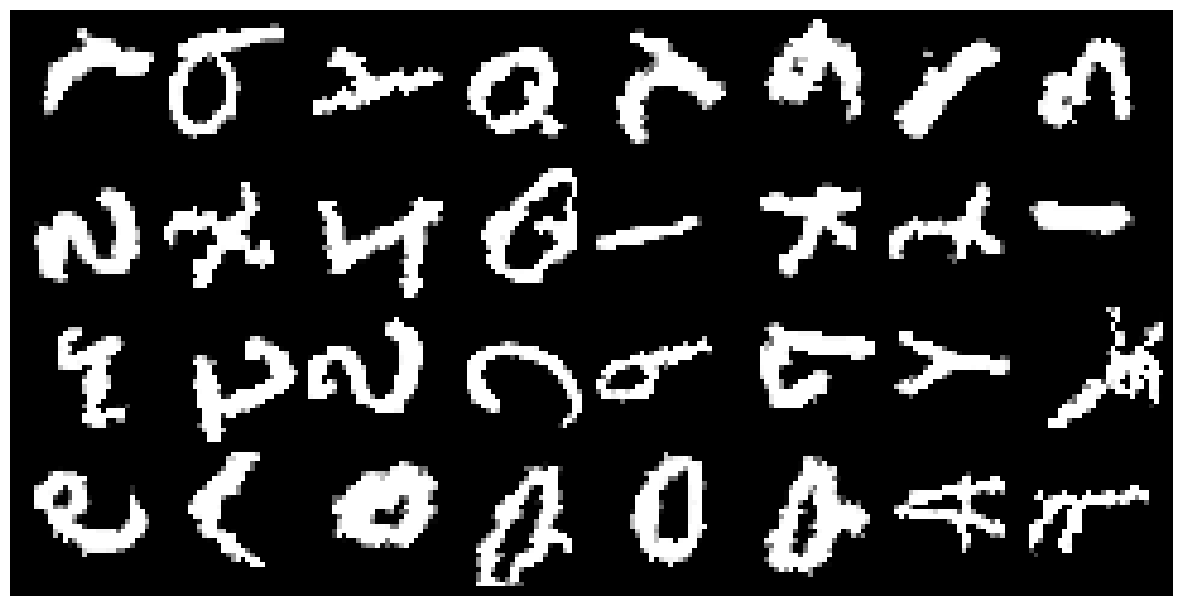

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from utils import save_checkpoint, load_checkpoint

def set_seed(seed):
    """Set seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)
torch.backends.cudnn.benchmark = True

# Data loading code remains the same
def get_data_loaders(batch_size: int, num_workers: int = 4):
    """
    Create data loaders for EMNIST dataset.
    """
    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1751,), std=(0.3332,))
    ])
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1751,), std=(0.3332,))
    ])

    # Using balanced split (47 classes)
    train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=train_transform)
    val_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader

def visualize_batch(dataloader):
    inputs, _ = next(iter(dataloader))
    out = vutils.make_grid(inputs)

    plt.figure(figsize=(15, 15))
    if out.shape[0] == 1:
        plt.imshow(out.squeeze().cpu(), cmap='gray')
    else:
        plt.imshow(out.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
    plt.close()


BATCH_SIZE : int= 32
train_loader, val_loader = get_data_loaders(BATCH_SIZE)
print(f'number of training images: {len(train_loader.dataset)}')
print(f'number of validation images: {len(val_loader.dataset)}')

visualize_batch(train_loader)

In [2]:
print(f"Class labels range: {set(train_loader.dataset.targets.numpy())}")

Class labels range: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)}


In [3]:
from cnn_model import ResidualCNN

# Hyperparameters
NUM_CLASSES : int = 27  # EMNIST balanced split has 47 classes
NUM_EPOCHS : int = 20
LEARNING_RATE : float = 0.001
CHECKPOINT_DIR : str = 'checkpoints'
LATEST_MODEL : str = 'latest_model_checkpoint_2.pth'
BEST_MODEL : str = 'best_model_checkpoint_2.pth'

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    checkpoint_dir: str = 'checkpoints'
) -> dict:
    """
    Train the model with checkpoint support and early stopping.
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    criterion = nn.CrossEntropyLoss()

    # Load checkpoint if available
    start_epoch, train_losses, train_accuracies, val_losses, val_accuracies, best_val_accuracy = load_checkpoint(
        model, optimizer, scheduler, checkpoint_dir, model_name=LATEST_MODEL
    )
    for e in range(len(train_accuracies)):
        print(f'Epoch {e+1}/{num_epochs}:')
        print(f'Train Loss: {train_losses[e]:.4f} | Train Acc: {train_accuracies[e]:.2f}%')
        print(f'Val Loss: {val_losses[e]:.4f} | Val Acc: {val_accuracies[e]:.2f}%\n')

    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }

    no_improvement_epochs = 0  # Count epochs without improvement
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': f'{100.*correct/total:.3f}%'})

        train_acc = 100. * correct / total
        train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)

        # Update learning rate
        scheduler.step(val_loss)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Check for improvement
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            no_improvement_epochs = 0  # Reset counter
        else:
            no_improvement_epochs += 1

        # Early stopping at next multiple of 5
        if no_improvement_epochs >= 3 and (epoch + 1) % 5 == 0:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Save checkpoint
        save_checkpoint(
            epoch + 1,  # Save next epoch number
            model,
            optimizer,
            scheduler,
            history['train_loss'],
            history['train_acc'],
            history['val_loss'],
            history['val_acc'],
            best_val_accuracy,
            is_best=(val_acc == best_val_accuracy),
            checkpoint_dir=checkpoint_dir,
            latest_path=LATEST_MODEL,
            best_path=BEST_MODEL
        )

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n')

    return history

# Assuming the required objects (train_loader, val_loader, etc.) are defined elsewhere
model = ResidualCNN(
    num_classes=NUM_CLASSES,
    initial_channels=32,
    num_layers=5,
    dropout_rate=0.5
)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    checkpoint_dir=CHECKPOINT_DIR
)

print("Training completed!")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")

Loading latest checkpoint...
Epoch 1/20:
Train Loss: 1.6271 | Train Acc: 47.17%
Val Loss: 0.5313 | Val Acc: 83.70%

Epoch 2/20:
Train Loss: 0.9498 | Train Acc: 69.79%
Val Loss: 0.3802 | Val Acc: 88.67%

Epoch 3/20:
Train Loss: 0.7451 | Train Acc: 76.53%
Val Loss: 0.3041 | Val Acc: 90.55%

Epoch 4/20:
Train Loss: 0.6229 | Train Acc: 80.75%
Val Loss: 0.2652 | Val Acc: 91.59%

Epoch 5/20:
Train Loss: 0.5508 | Train Acc: 83.23%
Val Loss: 0.2397 | Val Acc: 92.51%

Epoch 6/20:
Train Loss: 0.4909 | Train Acc: 85.37%
Val Loss: 0.2422 | Val Acc: 92.77%

Epoch 7/20:
Train Loss: 0.4482 | Train Acc: 86.53%
Val Loss: 0.2154 | Val Acc: 93.40%

Epoch 8/20:
Train Loss: 0.4157 | Train Acc: 87.59%
Val Loss: 0.2050 | Val Acc: 93.66%

Epoch 9/20:
Train Loss: 0.3926 | Train Acc: 88.50%
Val Loss: 0.1929 | Val Acc: 93.94%

Epoch 10/20:
Train Loss: 0.3741 | Train Acc: 88.88%
Val Loss: 0.2195 | Val Acc: 93.51%

Epoch 11/20:
Train Loss: 0.3392 | Train Acc: 89.98%
Val Loss: 0.2103 | Val Acc: 93.65%

Epoch 12/20:

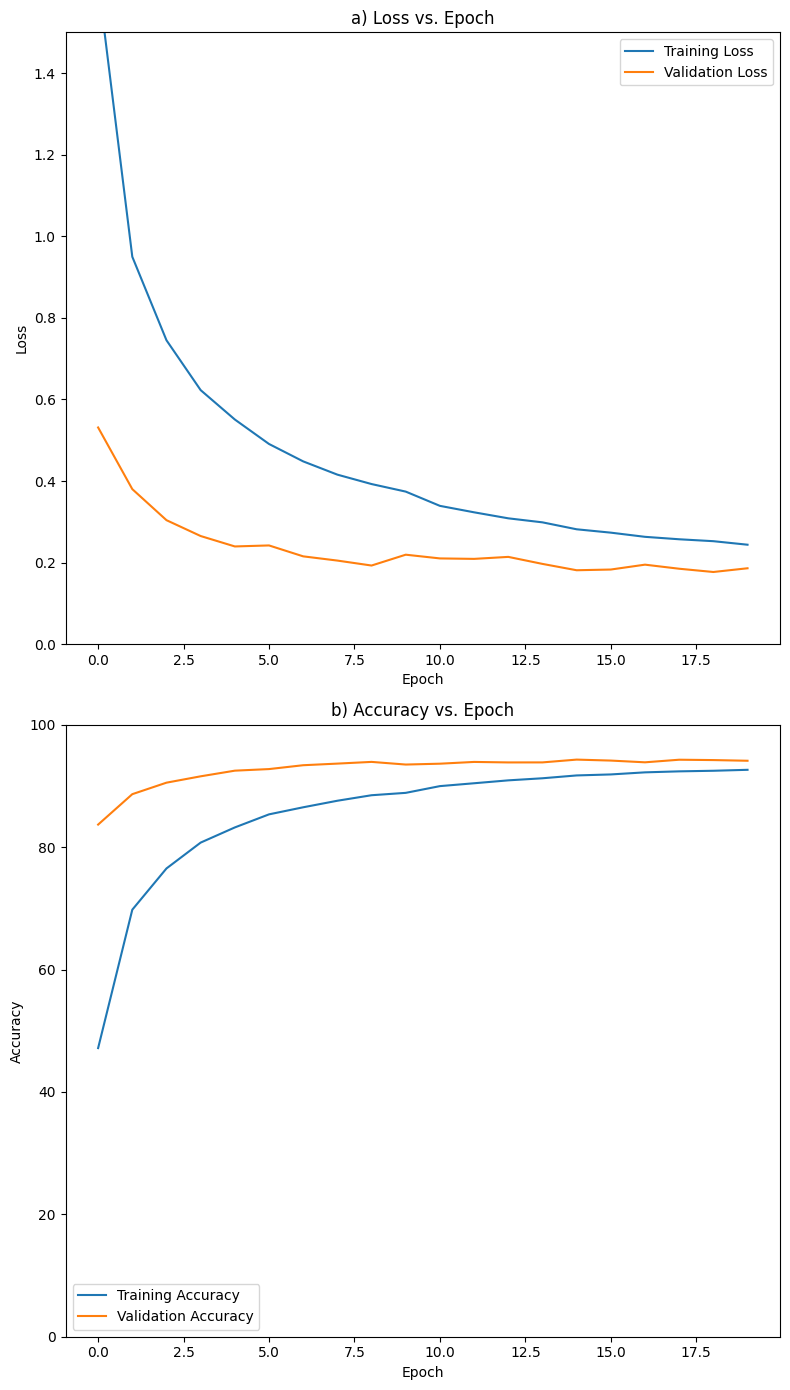

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14))

# Loss vs. Epoch
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('a) Loss vs. Epoch')
ax1.set_ylim(0.0, 1.5)

# Accuracy vs. Epoch
ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('b) Accuracy vs. Epoch')
ax2.set_ylim(0.0, 100)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()